In [1]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
            else:
                return None
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    return sources

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en',
                                      extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_data = {'page': page_name, 'text': page_name.text, 'link': page_name.fullurl,
                 'categories': [[y[9:] for y in list(page_name.categories.keys())]]}
    page_data_df = pd.DataFrame(page_data)
    return page_data_df

In [2]:
wiki_data = wiki_page('Bayer')

In [3]:
wiki_data.head()

,page,text,link,categories
0,"Bayer (id: 23748305, ns: 0)",Bayer AG (; German: [ˈbaɪɐ]) is a German multi...,https://en.wikipedia.org/wiki/Bayer,"[1863 establishments in Germany, Agriculture c..."


In [8]:
wiki_data.loc[0,'text'][:1000]

"Bayer AG (; German: [ˈbaɪɐ]) is a German multinational pharmaceutical and life sciences company and one of the largest pharmaceutical companies in the world. Headquartered in Leverkusen, Bayer's areas of business include human and veterinary pharmaceuticals; consumer healthcare products; agricultural chemicals, seeds and biotechnology products. The company is a component of the Euro Stoxx 50 stock market index. Werner Baumann has been CEO since 2016.Founded in Barmen in 1863 as a dyestuffs factory, Bayer's first and best-known product was aspirin. In 1898 Bayer trademarked the name heroin for the drug diacetylmorphine and marketed it as a cough suppressant and non-addictive substitute for morphine until 1910. Bayer also introduced phenobarbital; prontosil, the first widely used antibiotic and the subject of the 1939 Nobel Prize in Medicine; the antibiotic Cipro (ciprofloxacin); and Yaz (drospirenone) birth control pills.\nIn 1925 Bayer was one of six chemical companies that merged to 

In [9]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)


def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type

In [10]:
pairs = entity_pairs(wiki_data.loc[0,'text'])

Entity pairs extracted: 42


In [11]:
pairs.head()

,subject,relation,object,subject_type,object_type
0,Bayer's areas,include,human veterinary pharmaceuticals,ORG,NOUN_CHUNK
1,Bayer,introduced,phenobarbital,ORG,NOUN_CHUNK
2,Bayer CropScience,develops,genetically modified crops,ORG,NOUN_CHUNK
3,Aspirin,lost,Bayer's trademark,NOUN_CHUNK,ORG
4,sources,support,conflicting claims,NOUN_CHUNK,NOUN_CHUNK


In [12]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

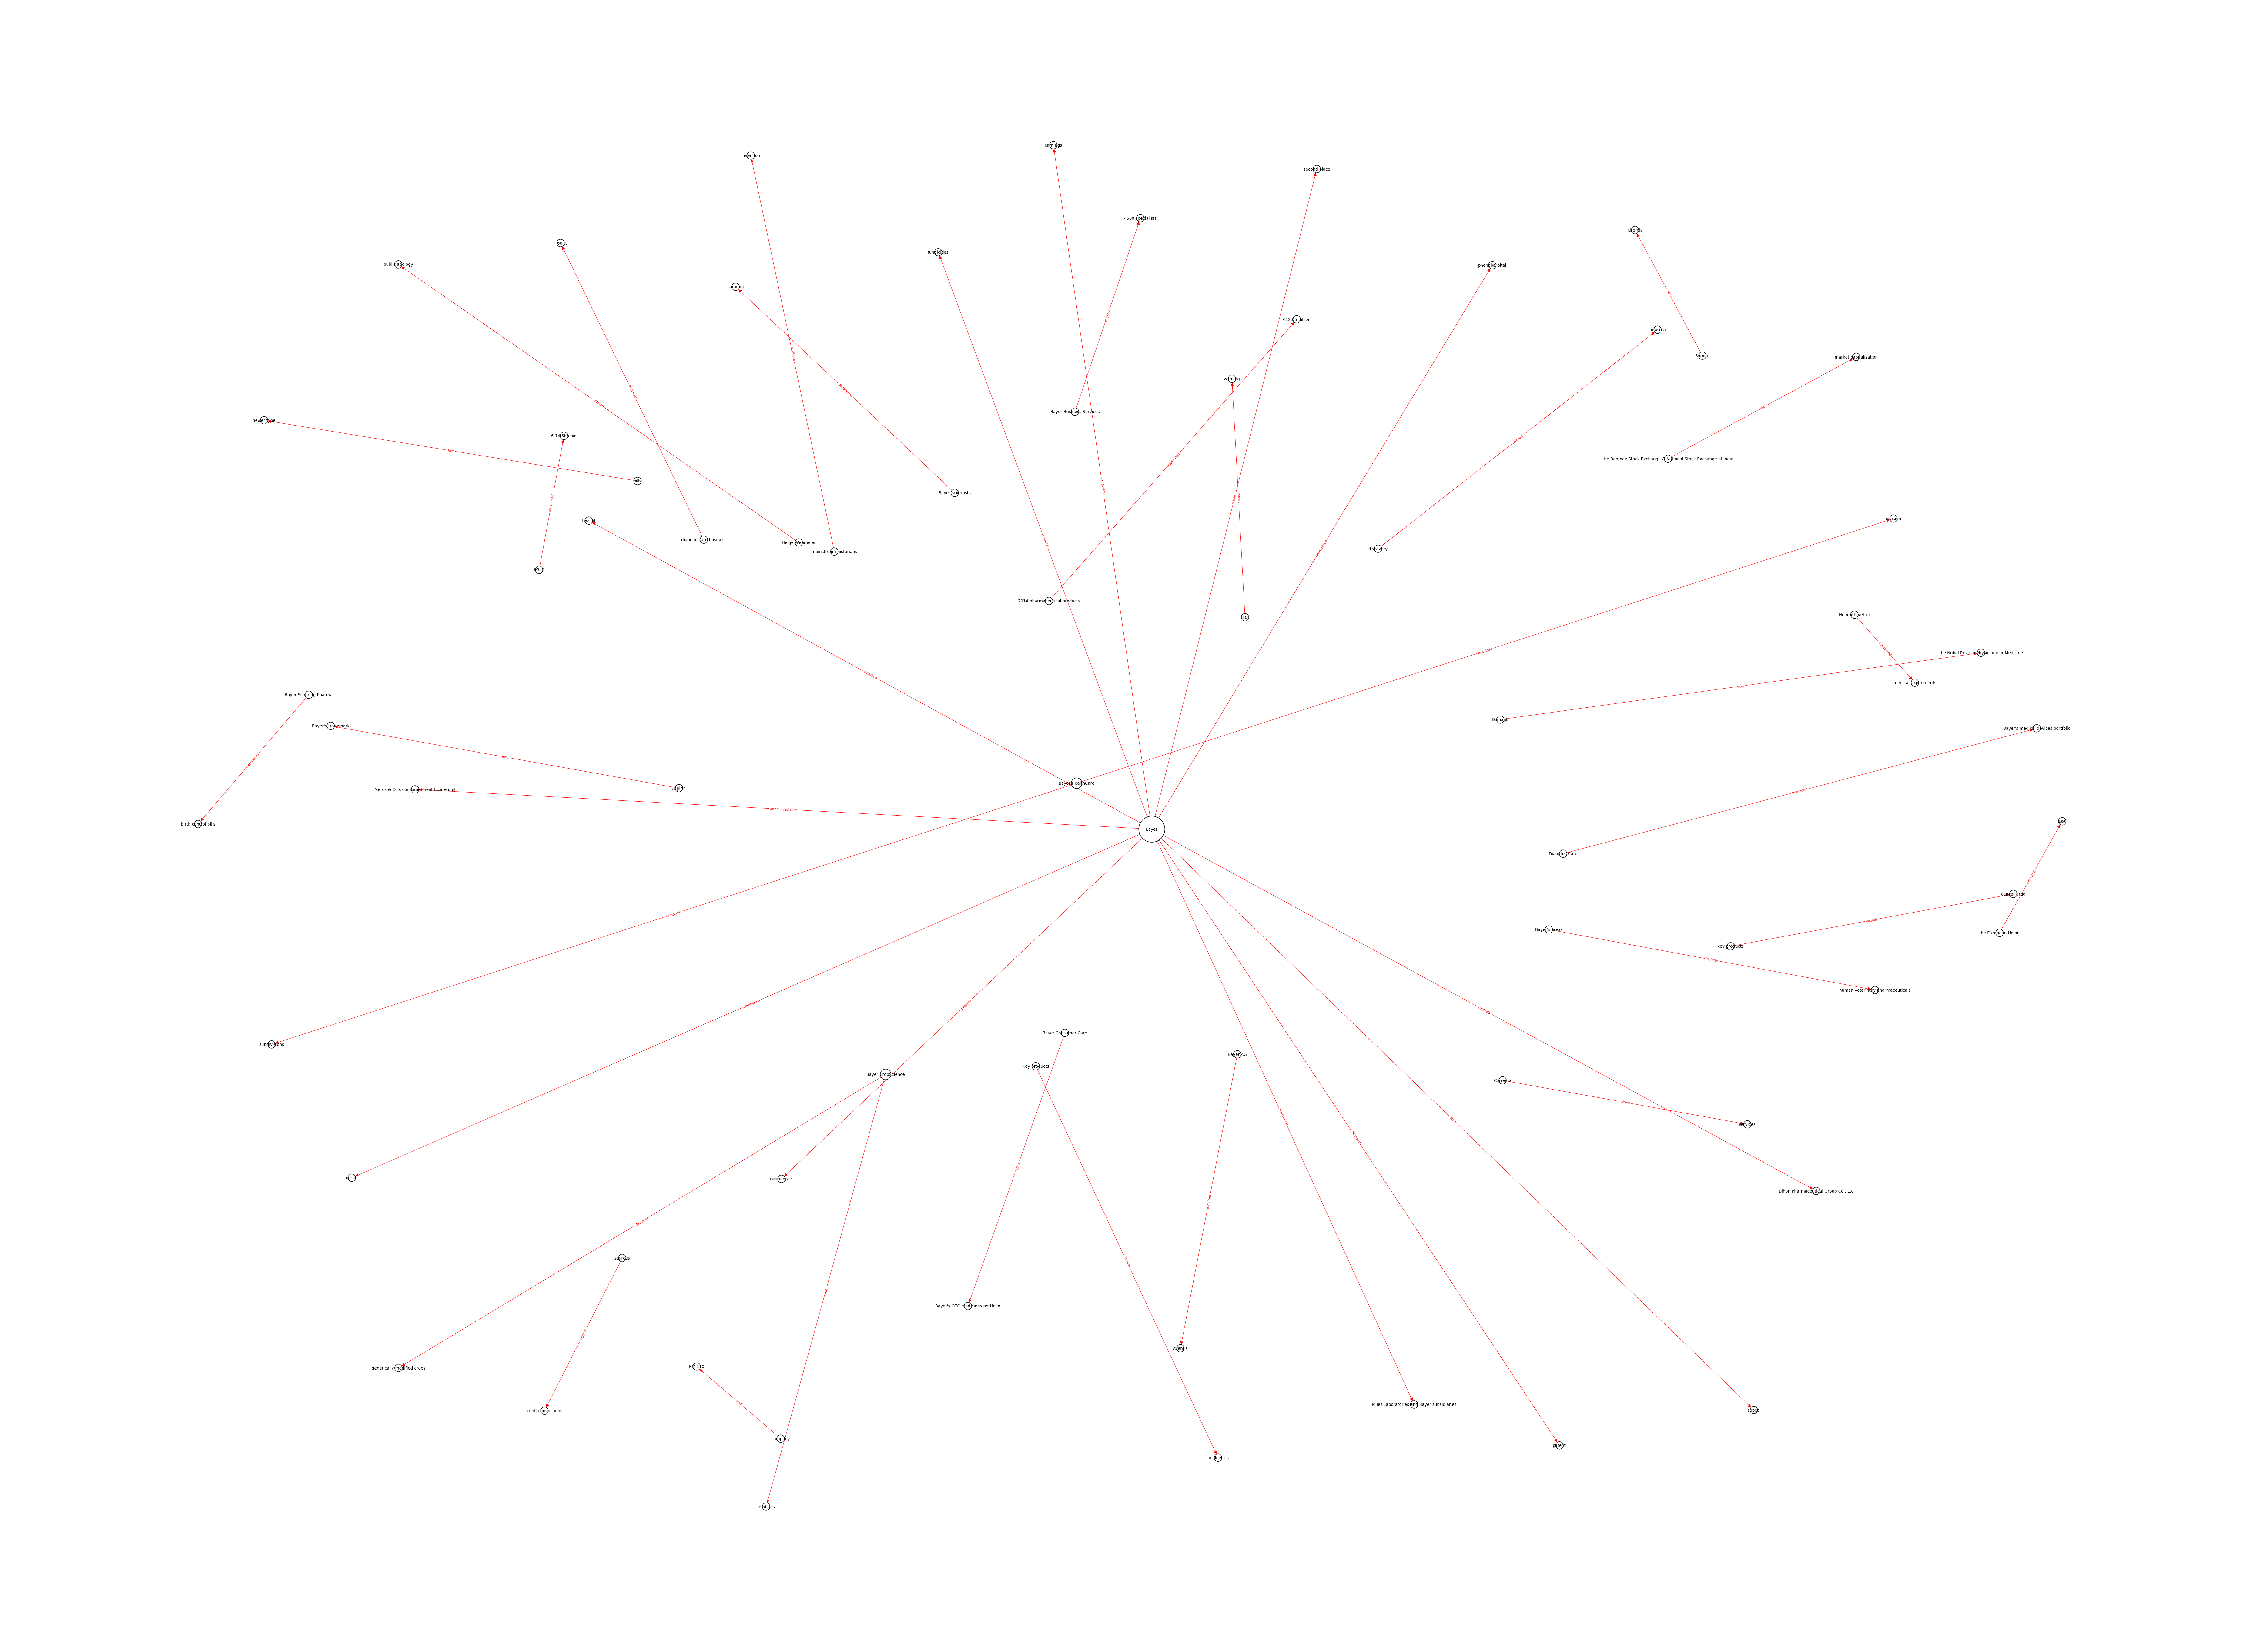

In [13]:
draw_kg(pairs)

In [14]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    print(k_graph.out_edges(data=False))
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

[("Bayer's areas", 'human veterinary pharmaceuticals'), ('Bayer', 'phenobarbital'), ('Bayer', 'patent'), ('Bayer', 'neuroleptic'), ('Bayer', 'Miles Laboratories and Bayer subsidiaries'), ('Bayer', 'fungicides'), ('Bayer', 'second place'), ('Bayer', 'merger'), ('Bayer', "Merck & Co's consumer health care unit"), ('Bayer', 'Dihon Pharmaceutical Group Co., Ltd'), ('Bayer', 'earnings'), ('Bayer', 'appeal'), ('Bayer', 'lawsuit'), ('Bayer CropScience', 'genetically modified crops'), ('Bayer CropScience', 'products'), ('Aspirin', "Bayer's trademark"), ('sources', 'conflicting claims'), ('mainstream historians', 'invention'), ('Bayer scientists', 'suramin'), ('discovery', 'new era'), ('Domagk', 'the Nobel Prize in Physiology or Medicine'), ('Helge Wehmeier', 'public apology'), ('Helmuth Vetter', 'medical experiments'), ('company', 'RM 170'), ('2014 pharmaceutical products', '€12.05 billion'), ('FDA', 'warning'), ('the European Union', 'use'), ('Bayer HealthCare', 'division'), ('Bayer HealthCar

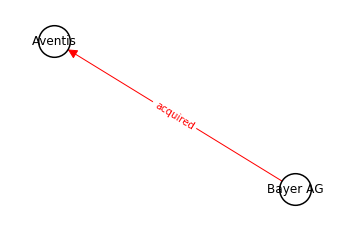

In [19]:
filter_graph(pairs, 'Bayer AG')

In [20]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name right after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation right after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location right after another location
    "I-LOC"    # Location
]

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very" \
           "close to the Manhattan Bridge."

# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")

outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)

print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])

[('[CLS]', 'O'), ('Hu', 'I-ORG'), ('##gging', 'I-ORG'), ('Face', 'I-ORG'), ('Inc', 'I-ORG'), ('.', 'O'), ('is', 'O'), ('a', 'O'), ('company', 'O'), ('based', 'O'), ('in', 'O'), ('New', 'I-LOC'), ('York', 'I-LOC'), ('City', 'I-LOC'), ('.', 'O'), ('Its', 'O'), ('headquarters', 'O'), ('are', 'O'), ('in', 'O'), ('D', 'I-LOC'), ('##UM', 'I-LOC'), ('##BO', 'I-LOC'), (',', 'O'), ('therefore', 'O'), ('very', 'O'), ('##c', 'O'), ('##lose', 'O'), ('to', 'O'), ('the', 'O'), ('Manhattan', 'I-LOC'), ('Bridge', 'I-LOC'), ('.', 'O'), ('[SEP]', 'O')]


In [21]:
sequence = "Headquartered in Leverkusen, Bayer's areas of business include human and veterinary pharmaceuticals; consumer healthcare products; agricultural chemicals, seeds and biotechnology products. Werner Baumann has been CEO since 2016."

# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")

outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)

print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])

[('[CLS]', 'O'), ('Head', 'O'), ('##qua', 'O'), ('##rter', 'O'), ('##ed', 'O'), ('in', 'O'), ('Lev', 'I-LOC'), ('##er', 'I-LOC'), ('##kus', 'I-LOC'), ('##en', 'I-LOC'), (',', 'O'), ('Bay', 'I-ORG'), ('##er', 'I-ORG'), ("'", 'O'), ('s', 'O'), ('areas', 'O'), ('of', 'O'), ('business', 'O'), ('include', 'O'), ('human', 'O'), ('and', 'O'), ('veterinary', 'O'), ('pharmaceutical', 'O'), ('##s', 'O'), (';', 'O'), ('consumer', 'O'), ('healthcare', 'O'), ('products', 'O'), (';', 'O'), ('agricultural', 'O'), ('chemicals', 'O'), (',', 'O'), ('seeds', 'O'), ('and', 'O'), ('bio', 'O'), ('##tech', 'O'), ('##nology', 'O'), ('products', 'O'), ('.', 'O'), ('Werner', 'I-PER'), ('Ba', 'I-PER'), ('##uman', 'I-PER'), ('##n', 'I-PER'), ('has', 'O'), ('been', 'O'), ('CEO', 'O'), ('since', 'O'), ('2016', 'O'), ('.', 'O'), ('[SEP]', 'O')]
